## Clustering

Clustering is an unsupervised learning approach used to group similar data points together based on their inherent characteristics. The goal is to identify patterns and structures in the dataset without prior knowledge of the labels. In this project, we hope to use clustering to discover meaningful subgroups within the patient population, which could help in understanding differences in treatment responses or outcomes, and potentially reveal patient phenotypes that benefit from specific interventions.


### 0. Preparing the Jupyter Notebook

To begin, we load the necessary libraries and import the prepared dataset. We will use **`patient_data_onehot_imputed`** as it already includes all preprocessing steps required for machine learning, except for **normalization or standardization**. This ensures we have a consistent and clean dataset ready for further analysis.


In [1]:
# Load libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

from scipy.stats import boxcox
from sklearn.preprocessing import PowerTransformer

In [2]:
# Loading the dataset
with open('data/patient_data_onehot_imputed.pkl', 'rb') as file:
    processed_data = pickle.load(file)
    
processed_data.head()

,age,rosc,cpc,hospital_A,hospital_B,hospital_D,hospital_E,hospital_F,sex_Female,sex_Male,ohca_False,ohca_True,ohca_Unknown,ttm_33.0,ttm_36.0,ttm_No TTM,shockable_rhythm_False,shockable_rhythm_True,shockable_rhythm_Unknown
0,53.0,18.0,1,True,False,False,False,False,False,True,False,True,False,True,False,False,False,True,False
1,85.0,7.0,1,False,False,False,False,True,True,False,True,False,False,False,False,True,True,False,False
2,48.0,18.0,1,True,False,False,False,False,False,True,False,True,False,False,True,False,False,True,False
3,45.0,18.0,1,True,False,False,False,False,False,True,False,True,False,True,False,False,False,True,False
4,51.0,24.0,1,False,False,True,False,False,False,True,False,True,False,True,False,False,False,True,False


### 1. Standardization or Normalization

Next, we determine whether **standardization** or **normalization** is appropriate for our dataset to ensure consistent feature scaling. To make an informed decision, we first visualize the distribution of the numerical features. Based on these distributions, we then apply the selected scaling technique to align the data for better performance in machine learning models.


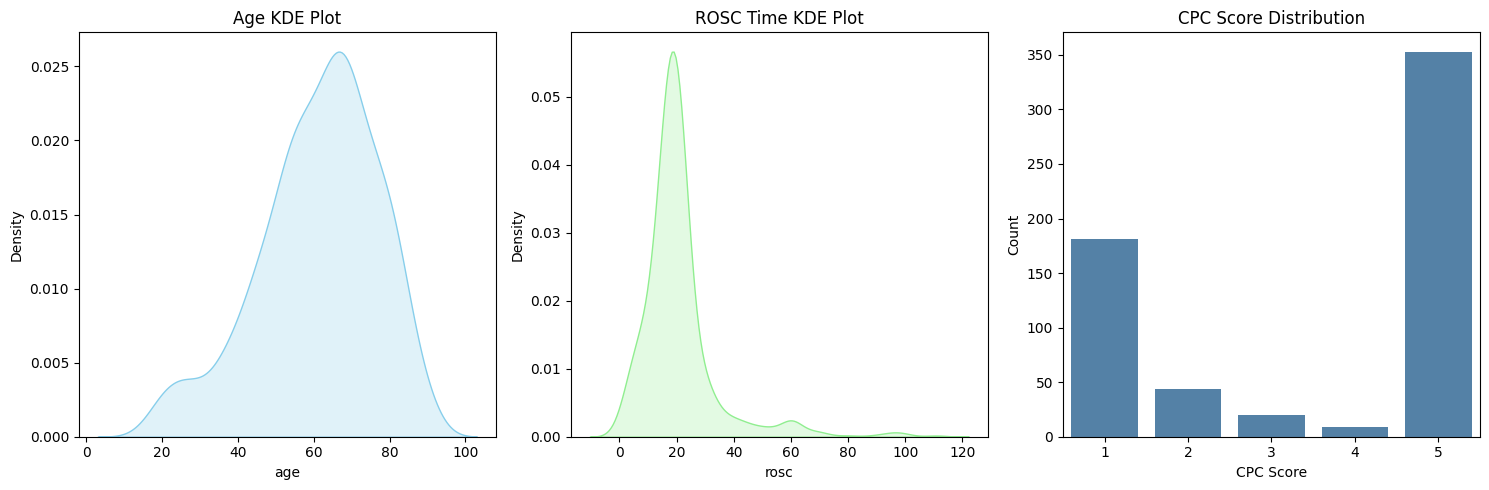

In [18]:
# Plotting count plot for CPC instead of KDE plot
plt.figure(figsize=(15, 5))

# Age KDE Plot
plt.subplot(1, 3, 1)
sns.kdeplot(processed_data['age'], fill=True, color='skyblue')
plt.title('Age KDE Plot')

# ROSC KDE Plot
plt.subplot(1, 3, 2)
sns.kdeplot(processed_data['rosc'], fill=True, color='lightgreen')
plt.title('ROSC Time KDE Plot')
# CPC Count Plot
plt.subplot(1, 3, 3)
sns.countplot(x='cpc', data=processed_data, color='steelblue')
plt.title('CPC Score Distribution')
plt.xlabel('CPC Score')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


In [7]:
# Display all unique ROSC times from the dataset
unique_rosc_times = processed_data['rosc'].unique()
unique_rosc_times_sorted = np.sort(unique_rosc_times)

# Print the unique ROSC times in sorted order
print(unique_rosc_times_sorted)

[  1.    2.    3.    4.    5.    6.    7.    8.    9.   10.   11.   12.
  13.   14.   15.   16.   17.   18.   19.   20.   21.   21.5  22.   24.
  25.   26.   27.   29.   30.   32.   33.   34.   35.   36.   37.   38.
  40.   42.   44.   45.   47.   50.   52.   54.   55.   60.   62.   63.
  67.   70.   80.   90.   95.   96.   98.  100.  111. ]


**Analysis**: The **age** distribution is approximately **normal**, with a slight skew towards lower values and a peak just below **70**. The **ROSC** distribution also appears roughly **normal**, but contains several significant **outliers** that need to be addressed before proceeding with further analysis. Eventhough **ROSC** appears to have negative values, it actually does not.

In [12]:


# Apply Box-Cox transformation to ROSC time
rosc_transformed_boxcox, lambda_value = boxcox(processed_data['rosc'])

# Adding the transformed ROSC data to the dataframe
processed_data['rosc_boxcox'] = rosc_transformed_boxcox

In [15]:


# Apply Yeo-Johnson transformation to ROSC time
power_transformer = PowerTransformer(method='yeo-johnson')
rosc_transformed = power_transformer.fit_transform(processed_data[['rosc']])

# Adding the transformed ROSC data to the dataframe
processed_data['rosc_yeojohnson'] = rosc_transformed

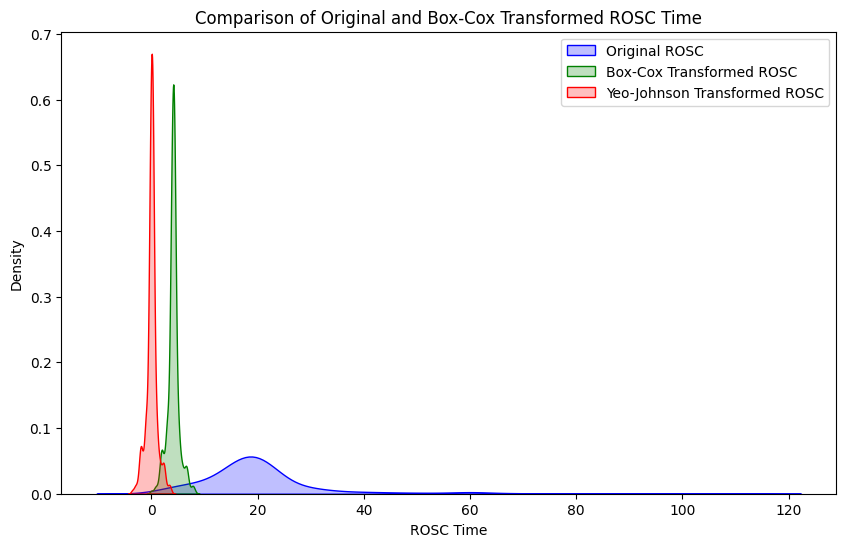

In [17]:
# Plotting original ROSC and Box-Cox transformed ROSC to compare
plt.figure(figsize=(10, 6))

# Original ROSC KDE Plot
sns.kdeplot(processed_data['rosc'], fill=True, color='blue', label='Original ROSC')

# Box-Cox Transformed ROSC KDE Plot
sns.kdeplot(processed_data['rosc_boxcox'], fill=True, color='green', label='Box-Cox Transformed ROSC')

# Apply Yeo-Johnson transformation to ROSC time
sns.kdeplot(processed_data['rosc_yeojohnson'], fill=True, color='red', label='Yeo-Johnson Transformed ROSC')

plt.title('Comparison of Original and Box-Cox Transformed ROSC Time')
plt.xlabel('ROSC Time')
plt.ylabel('Density')
plt.legend()
plt.show()


**Analysis**: Both the **Box-Cox** and **Yeo-Johnson** transformations effectively narrow the distribution, reducing the impact of high outliers. However, the **Box-Cox transformation** retains a slightly broader spread compared to **Yeo-Johnson**, making it preferable for preserving more variability in the data. Therefore, we will proceed with the **Box-Cox transformation**.

##### Standardization
After applying the **Box-Cox transformation** to handle skewness and reduce the influence of outliers, we proceed with **standardization**. Standardization rescales the features so that they have a mean of **0** and a standard deviation of **1**, which is particularly useful for models that assume normally distributed input data or are sensitive to feature scales.

By standardizing the data, we ensure that all features are on a comparable scale, which helps improve model performance and convergence during training.


### KMeans Clustering

For n_clusters = 2, the average silhouette score is: 0.25689397795837343
For n_clusters = 3, the average silhouette score is: 0.29887800934229686
For n_clusters = 4, the average silhouette score is: 0.31907147244488043
For n_clusters = 5, the average silhouette score is: 0.35178281054358795
For n_clusters = 6, the average silhouette score is: 0.3834849922231757
For n_clusters = 7, the average silhouette score is: 0.3929507216047965
For n_clusters = 8, the average silhouette score is: 0.42003820054110114
For n_clusters = 9, the average silhouette score is: 0.4324691403054838
For n_clusters = 10, the average silhouette score is: 0.4552382612628483


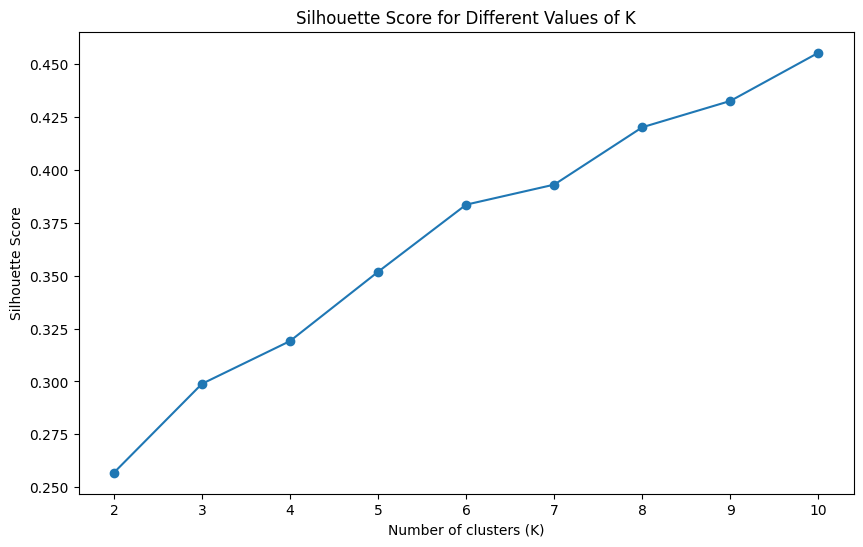

In [8]:
# Decide the number of k
# Initialize lists to hold values for plotting
silhouette_scores = []
k_values = range(2, 11)

# Iterate over different values of K
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=2023)
    cluster_labels = kmeans.fit_predict(scaled_data)
    silhouette_avg = silhouette_score(scaled_data, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {k}, the average silhouette score is: {silhouette_avg}")

# Plot silhouette scores to find the best K
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Values of K')
plt.show()

In [9]:
# Perform K-means clustering
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=2023)
kmeans.fit(scaled_data)

# Add cluster labels to the DataFrame
processed_data['cluster'] = kmeans.labels_

#Add outcome to the dataframe for analysis
processed_data['outcome'] = data['outcome']

# Display the first few rows of the data with cluster labels
processed_data.head()

,age,rosc,cpc,sex_Female,sex_Male,ohca_False,ohca_True,ohca_Unknown,shockable_rhythm_False,shockable_rhythm_True,shockable_rhythm_Unknown,ttm_33.0,ttm_36.0,ttm_No TTM,cluster,outcome
0,53.0,19.0,1,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0,Good
1,85.0,7.0,1,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,5,Good
2,48.0,19.0,1,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,8,Good
3,45.0,19.0,1,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0,Good
4,51.0,24.0,1,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0,Good


In [10]:
# Count the number of data points in each cluster
cluster_counts = processed_data['cluster'].value_counts()

# Display the counts for each cluster
print(cluster_counts)

cluster
0    156
2     97
4     70
1     65
9     59
3     54
8     39
5     30
6     27
7     10
Name: count, dtype: int64


### Cluster analysis

Cluster Summary (Means):
                age       rosc
cluster                      
0        61.000000  20.557692
1        62.876923  18.876923
2        62.371134  23.000000
3        63.055556  23.944444
4        58.642857  20.285714
5        66.800000  23.066667
6        65.925926  19.000000
7        48.500000  26.000000
8        60.025641  21.487179
9        56.884209  19.406780

Cluster Summary (Categorical Mode):
         cpc  sex_Female  sex_Male  ohca_False  ohca_True  ohca_Unknown  \
cluster                                                                  
0         1         0.0       1.0         0.0        1.0           0.0   
1         5         0.0       1.0         1.0        0.0           0.0   
2         5         0.0       1.0         0.0        1.0           0.0   
3         5         1.0       0.0         0.0        1.0           0.0   
4         1         1.0       0.0         0.0        1.0           0.0   
5         5         1.0       0.0         1.0        0.0  

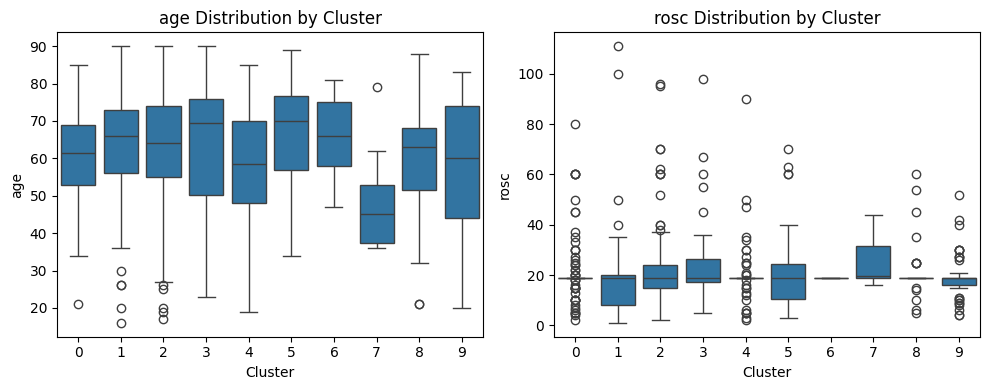

In [11]:
# Define your numeric and categorical features
numeric_features = ['age', 'rosc']
categorical_features = [
    'cpc', 'sex_Female', 'sex_Male', 
    'ohca_False', 'ohca_True', 'ohca_Unknown', 
    'shockable_rhythm_False', 'shockable_rhythm_True', 'shockable_rhythm_Unknown', 
    'ttm_33.0','ttm_36.0', 'ttm_No TTM'
    ]

# Calculate means for numeric features grouped by cluster
cluster_summary_numeric = processed_data.groupby('cluster')[numeric_features].mean()
print("Cluster Summary (Means):\n", cluster_summary_numeric)

# Calculate mode for categorical features grouped by cluster
cluster_summary_categorical = processed_data.groupby('cluster')[categorical_features].agg(lambda x: x.mode()[0] if len(x.mode()) > 0 else None)
print("\nCluster Summary (Categorical Mode):\n", cluster_summary_categorical)

# Visual Analysis
# Number of features to plot
num_features = len(numeric_features)

# Create a figure with subplots
fig, axes = plt.subplots(1, num_features, figsize=(5 * num_features, 4))  # Adjust figsize as needed

# Loop through the numeric features and create a box plot for each
for ax, feature in zip(axes, numeric_features):
    sns.boxplot(x='cluster', y=feature, data=processed_data, ax=ax)
    ax.set_title(f'{feature} Distribution by Cluster')
    ax.set_xlabel('Cluster')
    ax.set_ylabel(feature)

# Adjust layout
plt.tight_layout()
plt.show()

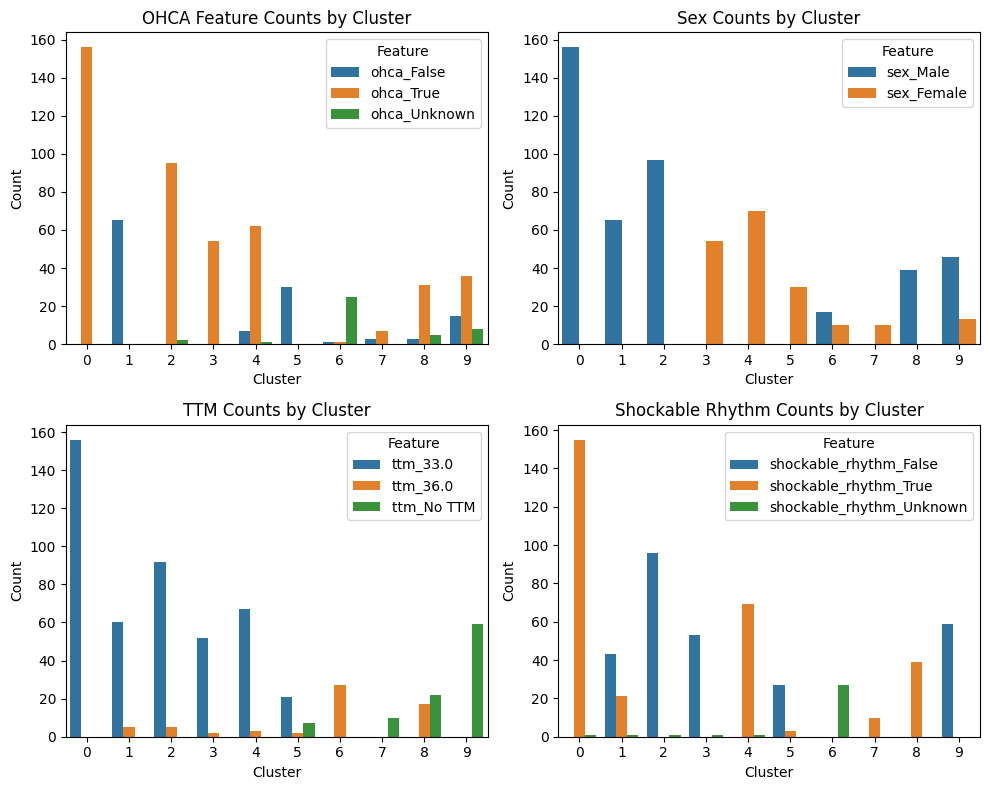

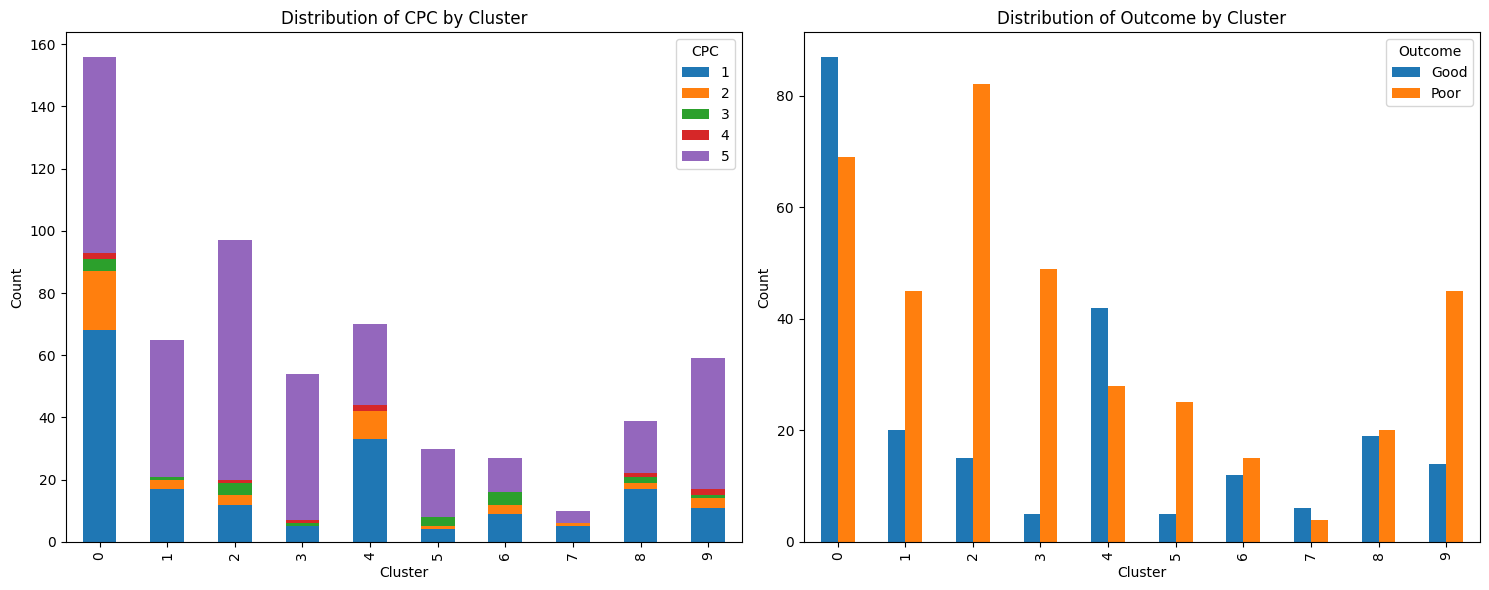

<Figure size 1000x600 with 0 Axes>

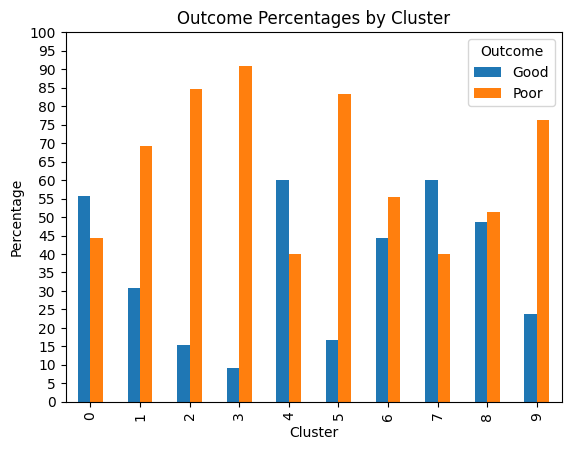

In [12]:
# Define features and titles for plotting
features_list = [
    (['ohca_False', 'ohca_True', 'ohca_Unknown'], 'OHCA Feature Counts by Cluster'),
    (['sex_Male', 'sex_Female'], 'Sex Counts by Cluster'),
    (['ttm_33.0', 'ttm_36.0', 'ttm_No TTM'], 'TTM Counts by Cluster'),
    (['shockable_rhythm_False', 'shockable_rhythm_True', 'shockable_rhythm_Unknown'], 'Shockable Rhythm Counts by Cluster')
]

# Calculate number of plots
num_plots = len(features_list)

# Determine number of rows and columns
num_rows = 2
num_cols = (num_plots + 1) // num_rows 

# Create a figure with subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 4 * num_rows))

# Flatten axes array for easy indexing if there are multiple rows
axes = axes.flatten()

# Loop through the features and create a bar plot for each
for ax, (features, title) in zip(axes, features_list):
    melted_data = processed_data.melt(id_vars='cluster', value_vars=features, 
                                       var_name='Feature', value_name='Count')
    sns.barplot(x='cluster', y='Count', hue='Feature', data=melted_data, estimator=sum, ax=ax, errorbar=None)
    ax.set_title(title)
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Count')
    ax.legend(title='Feature')

# Adjust layout
plt.tight_layout()
plt.show()

# Count the occurrences of each CPC value for each cluster with observed=True
cpc_counts = processed_data.groupby(['cluster', 'cpc'], observed=True).size().unstack(fill_value=0)

# Count the occurrences of each outcome value for each cluster with observed=True
outcome_counts = processed_data.groupby(['cluster', 'outcome'], observed=True).size().unstack(fill_value=0)

# Create a figure with 2 subplots (side by side)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # 1 row, 2 columns

# Create the stacked bar plot for CPC
cpc_counts.plot(kind='bar', stacked=True, ax=axes[0])
axes[0].set_title('Distribution of CPC by Cluster')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Count')
axes[0].legend(title='CPC')

# Create the stacked bar plot for Outcome
outcome_counts.plot(kind='bar', stacked=False, ax=axes[1])
axes[1].set_title('Distribution of Outcome by Cluster')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Count')
axes[1].legend(title='Outcome')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

# Calculate percentages for each cluster by dividing each count by the row sum
outcome_percentages = outcome_counts.div(outcome_counts.sum(axis=1), axis=0) * 100

# Create a new figure for percentages
plt.figure(figsize=(10, 6))

# Create a side-by-side bar plot with percentages
outcome_percentages.plot(kind='bar', stacked=False)

# Add labels and title
plt.title('Outcome Percentages by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Percentage')
plt.legend(title='Outcome')
plt.yticks(range(0, 101, 5))  # Adjust range as needed (0 to 100 for percentages)
plt.show()

### Clustering Result Analysis

The focus of this analysis is to identify the characteristics of cardiac arrest patients who can benefit from TTM (targeted temperature management). However, as observed, there is no cluster with significantly better outcomes compared to poor outcomes.

Nonetheless, several notable clusters warrant further analysis:

**Cluster 0**: This cluster has the highest count of good outcomes; however, the difference between good and poor outcomes is only 10%. 
- The characteristics of this cluster include a mean age of 61 years, a mean time to return of spontaneous circulation (ROSC) of 20 minutes, all cases being out-of-hospital cardiac arrests, all patients being male, all receiving TTM at 33°C, and a predominance of shockable rhythms.

**Cluster 2**: This cluster has the highest count of poor outcomes. 
- It features a mean age of 62 years, a mean time to ROSC of 23 minutes, a majority being out-of-hospital cardiac arrests, all patients being male, mostly receiving TTM at 33°C, and a predominance of unshockable rhythms.

**Cluster 4** and **Cluster 7**: These clusters exhibit the greatest percentage difference between good and poor outcomes. 
- Cluster 4 has a mean age of 58 years, a mean time to ROSC of 20 minutes, mostly comprising out-of-hospital cardiac arrests, all patients being female, predominantly receiving TTM at 33°C, and mostly having shockable rhythms. 
- Cluster 7 has a mean age of 48 years, a mean time to ROSC of 26 minutes, primarily consisting of out-of-hospital cardiac arrests, all patients being female, mostly receiving no TTM, and predominantly having shockable rhythms.
- The mean age of these clusters are younger compared to the others

**Cluster 9**: This cluster has a mean age below 60 years (56 years) but predominantly shows poor outcomes.
- The mean time to return of spontaneous circulation (ROSC) is 19 minutes, mostly comprises out-of-hospital cardiac arrests, primarily includes male patients, most patients did not receive targeted temperature management (TTM) and the majority have unshockable rhythms.

### Conclusion
1. Clusters 4 and 7 exhibit the greatest percentage difference between good and poor outcomes (20%), with good outcomes having a higher count, which may be due to a mean age of less than 60.
2. Although Cluster 9 has a mean age of less than 60, it predominantly shows poor outcomes. This difference may be attributed to the patients in Cluster 9 having unshockable rhythms.
3. Examining Clusters 2 and 9, it appears that patients with unshockable rhythms experience poor outcomes, regardless of whether they receive targeted temperature management (TTM) or not.